In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function
import import_ipynb
from handcrafted_descriptors.gabor_classification import utility as utility 
import pandas as pd

importing Jupyter notebook from /Users/admin/Desktop/tesi/Thesis/handcrafted_descriptors/gabor_classification/utility.ipynb


In [2]:
import numpy as np 



vector = np.array([0.5, 0.51,0.60, 0.48, 0.82, 0.72, 0.54, 0.46, 0.74, 0.82, 0.47, 0.70, 0.53, 0.81, 0.56, 0.51, 0.59, 0.59, 0.72, 0.41])
print('len: ',vector.shape)
print('mean: ',np.mean(vector))
print('std: ',np.std(vector))

len:  (20,)
mean:  0.604
std:  0.1269803134347998


In [3]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


## FUNCTIONS 

Functions to extract descriptors from matfile, build svm model and calculate accuracy

In [4]:
accuracy = []
precision = []
recall = []
f1score = []

## MAIN

-----------------------------
600
------------------------------
Best estimator found by grid search :  SVC(C=10.0, gamma=1, probability=True)
Accuracy score : 0.895


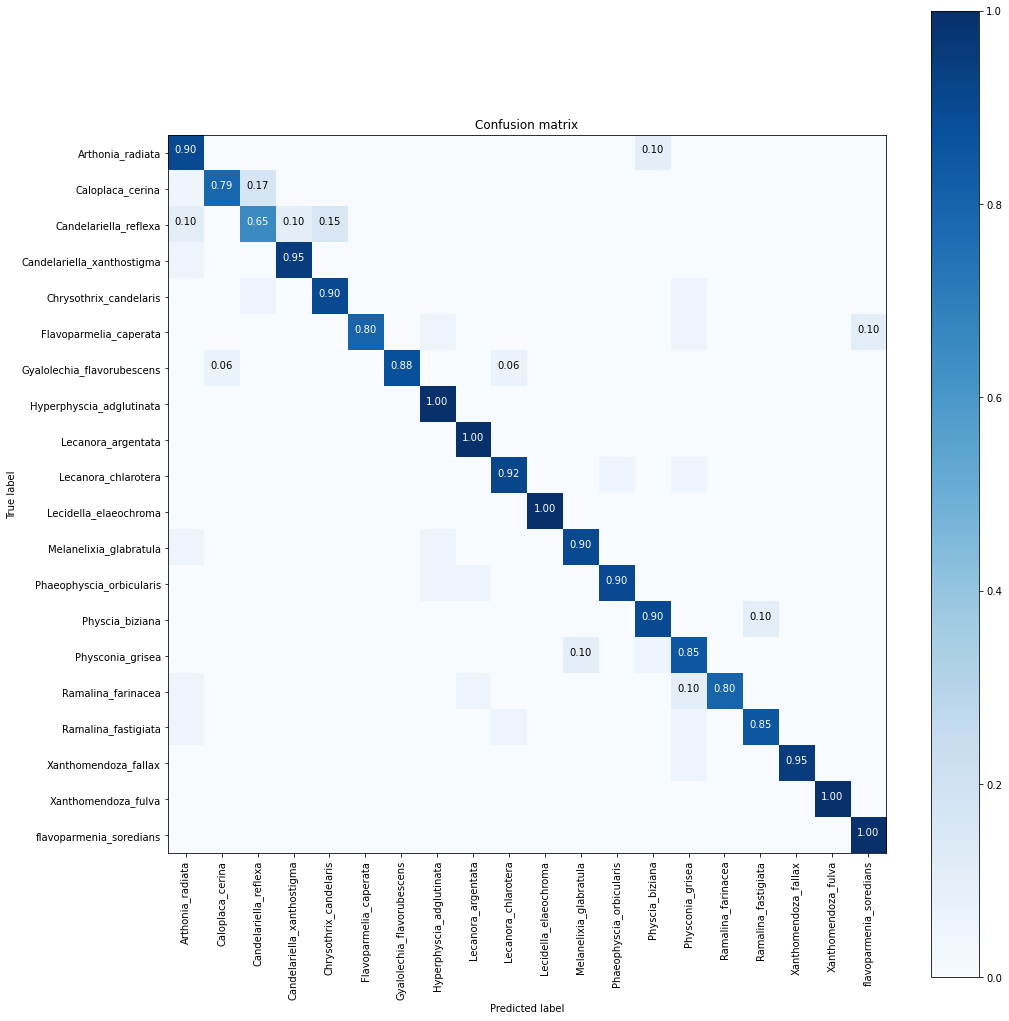

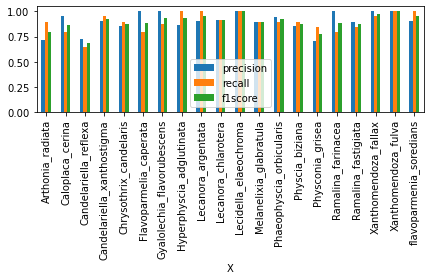

In [5]:

visual = [600]


accuracy = []
precision = []
recall = []
f1score = []


for i,vv in enumerate(visual):
    print('-----------------------------')
    print(vv)
    print('------------------------------')
    

    trf = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/training_features.mat'
    trlab = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/training_lab_features.mat'

    tstf = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/testing_features.mat'
    tstlab = '../../../features_for_python_4_opponent_phow/phowf_4_' + str(vv) +'_rbf/testing_lab_features.mat'



    training_feat,tr_lab = utility.load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = utility.load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1
    
    svm, score = utility.search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab, prob = True)
    name = "cm_best"
    direc = ""
    pred = utility.create_and_save_confusion_matrix(svm, tst_features, tst_lab, species,direc,name)
    
    a,b,c = utility.calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'precision_recall_class4classphow_4_600_')


    #knnacc, knnprec, knnrec ,_ = utility.train_knn_model_and_calculate_accuracy(training_feat, tr_lab, tst_features, tst_lab)   
    #utility.plot_and_save_knn(knnacc, knnprec, knnrec,'results/phow_4_opponent/knn/plotting_' + str(vv) + '.jpg')
    accuracy.append(np.mean(score))
    precision.append(np.mean(a))
    recall.append(np.mean(b))
    #f1score.append(np.mean(c))

In [26]:
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
prediction = svm.predict_proba(tst_features)
prediction.shape
roc_auc_score(tst_lab, prediction, multi_class='ovr')

0.9956369848532567

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(solver="liblinear").fit(X, y)
roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

0.9913333333333334

In [23]:
y.shape

(150,)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
prediction = svm.predict(tst_features)
conf_mat = confusion_matrix(prediction, tst_lab, normalize= 'true')
print('mean: ',np.mean(np.diag(conf_mat)))
print('std: ',np.std(np.diag(conf_mat)))
print('Classification Report')
target_names = ['Arthonia radiata','Caloplaca cerina','Candelariella reflexa','Candelariella xanthostigma',
                'Chrysothrix candelaris','Flavoparmelia caperata','Gyalolechia flavorubescens',
                'Hyperphyscia adglutinata'
        ,'Lecanora argentata','Lecanora chlarotera','Lecidella elaeochroma','Melanelixia glabratula'
        ,'Phaeophyscia orbicularis','Physcia biziana','Physconia grisea','Ramalina farinacea','Ramalina fastigiata',
                'Xanthomendoza fallax','Xanthomendoza fulva','flavoparmenia soredians']


print(classification_report(prediction, tst_lab, target_names=target_names))

In [ ]:
# plot precision recall and accuracy 
x1 = [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
plt.plot(x1, accuracy, label = "accuracy",color = 'r')
plt.plot(x1,precision, label = 'precision')
plt.plot(x1, recall, label = 'recall',color = 'g')
plt.xticks(x1)
plt.xlabel('number of words')
plt.ylabel('percentage %')
plt.grid()
plt.legend()
#plt.savefig('results/phow_6_opponent/total/acc_prec_rec.jpg')

In [ ]:
x1 = [200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
df = pd.DataFrame({"X":x1, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('number of visualwords')
plt.ylabel('Percentate %')
plt.tight_layout()
#plt.savefig('results/phow_6_opponent/total/acc_prec_rec_bar.jpg')

In [ ]:
accuracy

In [ ]:
from scipy.io import savemat,loadmat

# VARY THE GRIDSIZE

In [ ]:
visual = [4,6,8,12,16,32,64]

precision = []
recall = []
accuracy = []
f1score = []

for i,vv in enumerate(visual):
    print('-----------------------------')
    print(vv)
    print('------------------------------')
    



    trf = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(vv) + '_600_rbf/training_features.mat'
    trlab = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(vv) + '_600_rbf/training_lab_features.mat'

    tstf = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(vv) + '_600_rbf/testing_features.mat'
    tstlab = '../../../features_for_python_' + str(4) + '_opponent_phow/phowf_' + str(vv) + '_600_rbf/testing_lab_features.mat'



    training_feat,tr_lab = load_descriptor_from_matfile(trf, trlab)
    tst_features, tst_lab = load_descriptor_from_matfile(tstf,tstlab)

    tr_lab = tr_lab -1
    tst_lab = tst_lab -1
    
    svm, score = utility.search_for_best_rbf(training_feat, tr_lab, tst_features, tst_lab)
    name = "phow_"+str(vv)+'_600_opponent_'
    direc = ""
    pred = utility.create_and_save_confusion_matrix(svm, tst_features, tst_lab, species,direc,name)
    
    a,b,c = utility.calculate_and_plot_precision_recall(tst_lab, pred, species, '', 'phow_' + str(vv) +'_500_opponent')
    

    
    accuracy.append(np.mean(score))
    precision.append(np.mean(a))
    recall.append(np.mean(b))
    f1score.append(np.mean(c))

In [ ]:
df = pd.DataFrame({"X":visual, "precision":precision,"recall":recall,'accuracy': accuracy})
df.plot(x="X", y=["precision", "recall",'accuracy'], kind="bar")
plt.grid()
plt.xlabel('density of the grid (in pixel)')
plt.ylabel('Percentate %')
plt.tight_layout()
#plt.savefig('results/grid_results/phow_600/total/acc_prec_rec.jpg')